# Twitter Dogs Data Wrangling

In this project we will retrieve data from twitter using an archive file that contains tweets ID's.

Then, we will clean at least eight data quality issues and two tidiness issues in our dataset.



In [1861]:
#Import modules, packages

import requests
import json
import pandas as pd
import numpy as np
import tweepy
import time
import matplotlib.pyplot as plt
from pandas import Grouper

%matplotlib inline

## Gathering Data

We will collect data from three sources:
1. Archived tweets - A file we downloaded and is in our computer files
2. Image predictions - A file that is on a server and we need to get it through a GET request and save it to a local file
3. API tweets - Data obtained from the Twitter API using tweet ID's from the Archived tweets files. One all requests are made, we store the data in a file

We will gather data in the order above .

### Archived Tweets

Since we have the file in our local directory, we only need to load it to a pandas dataframe.

In [110]:
# load the archive file
df_arch = pd.read_csv('twitter-archive-enhanced.csv')
df_arch.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [127]:
# Check size of the archive file
print('Rows: {}, Columns: {}'.format(df_arch.shape[0],df_arch.shape[1]))

Rows: 2356, Columns: 17


### Image Predictions

In order to obtain the image predictions file, we will need to put a GET request to a server and parse the HTTP response to extract the file content. Then, we can store it to a file and then read it into a pandas dataframe.

In [12]:
# retrieve image prediction file from a server using requests
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

In [13]:
# write the http response content-text into a file
with open('image-predictions.tsv','w') as file:
    file.write(r.text)

In [128]:
# read image predictions file into a dataframe
df_pred = pd.read_csv('image-predictions.tsv', sep='\t')
df_pred.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### API Tweets

Finally, we want to gather data from the Twitter API. In order to do this, we will need to have a twitter account and create a developer account. Once, the developer account has been created one can create an app and this will give a set of codes to interact with Twitter API. The codes are consumer_key, consumer_secret, access_token and access_token_secret. Such codes, allow us to programatically ask request to the twitter API. Then, we will need to use the tweepy library to create an object that interacts with the twitter API and grants us access using the codes mentioned above.
Once we have granted access to put request to the Twitter API, we can use the archived tweets ID's to ask for information regarding such tweets. 

>**Note:** Be aware that the Twitter API has rate limits, which means after a certain amount fo request it will force a delay wait time before a new request is replied. You can automate the program to wait setting to True the parameters `wait_on_rate_limit` and `wait_on_rate_limit_notify` when creating an instance of the tweepy.API.

**Important:** Never share in Github or anywhere public your `consumer_key`, `consumer_secret`, `access_token` and `access_token_secret` !!!

In [21]:
# Obtaining the authorization keys from a file to avoid sharing them publicly
with open('twitterAPI-keys.txt','r') as json_file:
    twitter_keys = json.load(json_file)

consumer_key = twitter_keys['consumer']['key']
consumer_secret = twitter_keys['consumer']['secret']

access_token = twitter_keys['access']['token']
access_token_secret = twitter_keys['access']['token_secret']

In [41]:
# obtaining access to the Twitter API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Configuring the twitter API to use our keys and to automatically wait when the rate limit is reached
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [81]:
# example on how to retrieve a tweet using an ID
tweet_id = 666020888022790149
tweet = api.get_status(tweet_id, tweet_mode='extended')
print(tweet)

Status(geo=None, in_reply_to_screen_name=None, in_reply_to_user_id_str=None, user=User(contributors_enabled=False, id=4196983835, profile_banner_url='https://pbs.twimg.com/profile_banners/4196983835/1525830435', id_str='4196983835', is_translator=False, _json={'profile_image_url_https': 'https://pbs.twimg.com/profile_images/948761950363664385/Fpr2Oz35_normal.jpg', 'following': False, 'default_profile_image': False, 'created_at': 'Sun Nov 15 21:41:29 +0000 2015', 'profile_sidebar_fill_color': '000000', 'contributors_enabled': False, 'statuses_count': 8536, 'id': 4196983835, 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png', 'is_translator': False, 'notifications': False, 'profile_banner_url': 'https://pbs.twimg.com/profile_banners/4196983835/1525830435', 'id_str': '4196983835', 'protected': False, 'profile_link_color': 'F5ABB5', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png', 'verified': True, 'profile_use_backg

In [84]:
# Accessing the tweet status JSON object gotten from Twitter API response
tweet._json

{'contributors': None,
 'coordinates': None,
 'created_at': 'Sun Nov 15 22:32:08 +0000 2015',
 'display_text_range': [0, 131],
 'entities': {'hashtags': [],
  'media': [{'display_url': 'pic.twitter.com/BLDqew2Ijj',
    'expanded_url': 'https://twitter.com/dog_rates/status/666020888022790149/photo/1',
    'id': 666020881337073664,
    'id_str': '666020881337073664',
    'indices': [108, 131],
    'media_url': 'http://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg',
    'sizes': {'large': {'h': 720, 'resize': 'fit', 'w': 960},
     'medium': {'h': 720, 'resize': 'fit', 'w': 960},
     'small': {'h': 510, 'resize': 'fit', 'w': 680},
     'thumb': {'h': 150, 'resize': 'crop', 'w': 150}},
    'type': 'photo',
    'url': 'https://t.co/BLDqew2Ijj'}],
  'symbols': [],
  'urls': [],
  'user_mentions': []},
 'extended_entities': {'media': [{'display_url': 'pic.twitter.com/BLDqew2Ijj',
    'expanded_url': 'https://twitter.com/dog_

In [93]:
# Example dictionary of how to extract the desired fields from the tweet status JSON object
t = { 'id' : tweet._json['id_str'],
        'favorite_count' : tweet._json['favorite_count'],
        'retweeted': tweet._json['retweeted'],
        'retweet_count': tweet._json['retweet_count'],
        'full_text': tweet._json['full_text'],
        'media_url': tweet._json['entities']['media'][0]['media_url'],
        'source': tweet._json['source'] }
t

{'favorite_count': 2560,
 'full_text': 'Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj',
 'id': '666020888022790149',
 'media_url': 'http://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg',
 'retweet_count': 513,
 'retweeted': False,
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'}

In [105]:
# Functions to retrieve a tweet and store the desired data from it into a dictionary

def getTweetfromID(tweet_id):
    """
    Function to retrieve a tweet from Twitter API using the tweet ID
    
    parameters:
        @tweet_id: tweet ID to use to retrieve a tweet
        
    return:
        @tweet: the tweet retrieved, and None if there was no tweet retrieved
    """
    tweet = None
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended')
    except tweepy.TweepError as e:
        # Example format [{"message":"Sorry, that page does not exist","code":34}]
        #print(e.__dict__) # full http response
        print('Exception for tweet ID {}: {} '.format(tweet_id, e))
    return tweet


def storeTweetdata(tweet, tweet_dict):
    """
    Function to store the desired tweet data from a tweet status JSON object
    
    parameters:
        @tweet: tweet status JSON object obtained from twitter API
        @tweet_dict: dictionary in which the data is getting stored
        
    return:
        @tweet_dict: returns the same dictionary in which the data is getting stored
    """
    tweet_json = tweet._json
    
    tweet_dict['tweet_id'].append(tweet_json['id_str'])
    tweet_dict['favorite_count'].append(tweet_json['favorite_count'])
    tweet_dict['retweeted'].append(tweet_json['retweeted'])
    tweet_dict['retweet_count'].append(tweet_json['retweet_count'])
    tweet_dict['full_text'].append(tweet_json['full_text'])
    
    if 'media' in tweet_json['entities']:
        tweet_dict['media_url'].append(tweet_json['entities']['media'][0]['media_url'])
    else:
        tweet_dict['media_url'].append(np.nan)
        
    tweet_dict['source'].append(tweet_json['source'])
    
    return tweet_dict


In [106]:
# retrieving and storing all tweets from Twitter API using archived files tweet_id

batch = 1
BATCH_SIZE = 180
initial_id = 1
last_id = 0

fail_tweet_ids =[]

tweet_dict = { 'tweet_id' : [],
                'favorite_count' : [],
                'retweeted': [],
                'retweet_count': [],
                'full_text': [],
                'media_url': [],
                'source': [] 
                }

start = time.process_time()
with open('tweet_json.txt', 'a', encoding='UTF-8') as file:
    for count_id, tweet_id in enumerate(df_arch['tweet_id'],1):
        
        last_id = count_id

        # get tweet
        tweet = getTweetfromID(tweet_id)

        # store tweet
        if tweet is not None:
            # store raw json
            json.dump(tweet, file)
            file.write('\n')
            
            # store refined tweet data
            tweet_dict = storeTweetdata(tweet, tweet_dict)
        else:
            fail_tweet_ids.append(tweet_id)

        # display statistics
        if count_id%BATCH_SIZE == 0:

            end = time.process_time()
            ellapsed_time = end - start
            print('\n--------- Batch {} IDs: {}-{}, Ellapsed time: {} ---------\n'.\
                  format(batch, initial_id, last_id, ellapsed_time))
            batch +=1
            intial_id = last_id
            start = time.process_time()

    end = time.process_time()
    ellapsed_time = end - start
    print('\n--------- Batch {} IDs: {}-{}, ellapsed time: {} ---------\n'.\
          format(batch, initial_id, last_id, ellapsed_time))


Exception for tweet ID 888202515573088257: [{'message': 'No status found with that ID.', 'code': 144}] 
Exception for tweet ID 873697596434513921: [{'message': 'No status found with that ID.', 'code': 144}] 
Exception for tweet ID 869988702071779329: [{'message': 'No status found with that ID.', 'code': 144}] 
Exception for tweet ID 866816280283807744: [{'message': 'No status found with that ID.', 'code': 144}] 
Exception for tweet ID 861769973181624320: [{'message': 'No status found with that ID.', 'code': 144}] 

--------- Batch 1 IDs: 1-180, Ellapsed time: 4.3216719999999995 ---------

Exception for tweet ID 845459076796616705: [{'message': 'No status found with that ID.', 'code': 144}] 
Exception for tweet ID 842892208864923648: [{'message': 'No status found with that ID.', 'code': 144}] 
Exception for tweet ID 837012587749474308: [{'message': 'No status found with that ID.', 'code': 144}] 

--------- Batch 2 IDs: 1-360, Ellapsed time: 4.325434000000001 ---------

Exception for twe

Rate limit reached. Sleeping for: 652


Exception for tweet ID 754011816964026368: [{'message': 'No status found with that ID.', 'code': 144}] 

--------- Batch 6 IDs: 1-1080, Ellapsed time: 4.394260999999993 ---------


--------- Batch 7 IDs: 1-1260, Ellapsed time: 4.348782000000007 ---------


--------- Batch 8 IDs: 1-1440, Ellapsed time: 4.342611000000005 ---------


--------- Batch 9 IDs: 1-1620, Ellapsed time: 4.388689999999997 ---------



Rate limit reached. Sleeping for: 686



--------- Batch 10 IDs: 1-1800, Ellapsed time: 4.370533999999999 ---------


--------- Batch 11 IDs: 1-1980, Ellapsed time: 4.436374999999998 ---------


--------- Batch 12 IDs: 1-2160, Ellapsed time: 4.388532999999995 ---------


--------- Batch 13 IDs: 1-2340, Ellapsed time: 4.381236999999999 ---------


--------- Batch 14 IDs: 1-2356, ellapsed time: 0.38497099999999307 ---------



In [107]:
# read tweets data obtained from the API into dataframe
df_api = pd.DataFrame(tweet_dict)
df_api.head(5)

,favorite_count,full_text,media_url,retweet_count,retweeted,source,tweet_id
0,38520,This is Phineas. He's a mystical boy. Only eve...,http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,8499,False,"<a href=""http://twitter.com/download/iphone"" r...",892420643555336193
1,33027,This is Tilly. She's just checking pup on you....,http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,6247,False,"<a href=""http://twitter.com/download/iphone"" r...",892177421306343426
2,24861,This is Archie. He is a rare Norwegian Pouncin...,http://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,4139,False,"<a href=""http://twitter.com/download/iphone"" r...",891815181378084864
3,41920,This is Darla. She commenced a snooze mid meal...,http://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,8615,False,"<a href=""http://twitter.com/download/iphone"" r...",891689557279858688
4,40068,This is Franklin. He would like you to stop ca...,http://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,9354,False,"<a href=""http://twitter.com/download/iphone"" r...",891327558926688256


In [108]:
# Store data into csv file
df_api.to_csv('tweet_json_refined.txt', index=False)

### Data Gathering Checkpoint

The data has been stored in their corresponding files, so that one can read the data from the files.

In [146]:
# read tweets API file into dataframe
df_api = pd.read_csv('tweet_json_refined.txt')
df_api.head(5)

,favorite_count,full_text,media_url,retweet_count,retweeted,source,tweet_id
0,38520,This is Phineas. He's a mystical boy. Only eve...,http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,8499,False,"<a href=""http://twitter.com/download/iphone"" r...",892420643555336193
1,33027,This is Tilly. She's just checking pup on you....,http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,6247,False,"<a href=""http://twitter.com/download/iphone"" r...",892177421306343426
2,24861,This is Archie. He is a rare Norwegian Pouncin...,http://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,4139,False,"<a href=""http://twitter.com/download/iphone"" r...",891815181378084864
3,41920,This is Darla. She commenced a snooze mid meal...,http://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,8615,False,"<a href=""http://twitter.com/download/iphone"" r...",891689557279858688
4,40068,This is Franklin. He would like you to stop ca...,http://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,9354,False,"<a href=""http://twitter.com/download/iphone"" r...",891327558926688256


## Assessing Data

Once the data was gathered, we can start assessing the data and checking what is dirty and what is messy.

### Visual Assessment

We start using pandas, but if not all data is shown we will need to use a spreadsheet software such as Google sheets.

#### Archived Tweets

In [114]:
# brief inspection of dataset structure of archived data enhanced
df_arch

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


#### Image Predictions Dataset

In [129]:
# brief inspection of dataset structure of the image predictions of breed of dogs using a CNN
df_pred

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


We could notice that there are many different breeds predicted and that there are some predictions that do not consider the image a dog. An example is a `tweet_id` declared as desktop in the prediction, but actually being a dog looking at a PC screen.
However, there are also predictions that are not dogs, such as a `tweet_id` of a guinea pig.

In [153]:
# display the archived data of the tweet_id of the dog considered a desktop
df_arch[df_arch['tweet_id'] == 666268910803644416]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2337,666268910803644416,NaN,NaN,2015-11-16 14:57:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Very concerned about fellow dog trapped in com...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666268910...,10,10,None,None,None,None,None


Checking for a tweet_id declared as guinea pig in the prediction and actually being a guinea pig.

In [154]:
# display the archived data of the guinea pig image
df_arch[df_arch['tweet_id'] == 666362758909284353]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2330,666362758909284353,NaN,NaN,2015-11-16 21:10:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Unique dog here. Very small. Lives in containe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666362758...,6,10,None,None,None,None,None


Apparently someone wanted to cheat **WeRateDogs** and it might be good to see if the guinea pig tweet id exists in the tweeter data gotten from API, otherwise this tweet was deleted.

In [156]:
# check if the guinea pig tweet id exists in the tweets retrieved form the twitter API
df_api[df_api['tweet_id'] == 666362758909284353]

,favorite_count,full_text,media_url,retweet_count,retweeted,source,tweet_id
2317,778,Unique dog here. Very small. Lives in containe...,http://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,568,False,"<a href=""http://twitter.com/download/iphone"" r...",666362758909284353


The tweet was not deleted despite it was not a dog, maybe we should check another tweet of a non-dog picture

In [157]:
# checking another tweet id of a non-dog picture
df_api[df_api['tweet_id'] == 666411507551481857]

,favorite_count,full_text,media_url,retweet_count,retweeted,source,tweet_id
2313,445,This is quite the dog. Gets really excited whe...,http://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,325,False,"<a href=""http://twitter.com/download/iphone"" r...",666411507551481857


Ok another tweet of a non-dog picture exists in the tweets retrived from the API, which means it was not deleted. This makes more of a mystery why we have missing records in our dataset retrieved from the API. However, this also will need to be listed as quality issue since we only want dogs data and not other animals or things.

#### Tweets from API

In [151]:
# getting familiar with the structure of the tweets gotten from the API and the tweet id's on the archived data
df_api

,favorite_count,full_text,media_url,retweet_count,retweeted,source,tweet_id
0,38520,This is Phineas. He's a mystical boy. Only eve...,http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,8499,False,"<a href=""http://twitter.com/download/iphone"" r...",892420643555336193
1,33027,This is Tilly. She's just checking pup on you....,http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,6247,False,"<a href=""http://twitter.com/download/iphone"" r...",892177421306343426
2,24861,This is Archie. He is a rare Norwegian Pouncin...,http://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,4139,False,"<a href=""http://twitter.com/download/iphone"" r...",891815181378084864
3,41920,This is Darla. She commenced a snooze mid meal...,http://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,8615,False,"<a href=""http://twitter.com/download/iphone"" r...",891689557279858688
4,40068,This is Franklin. He would like you to stop ca...,http://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,9354,False,"<a href=""http://twitter.com/download/iphone"" r...",891327558926688256
5,20089,Here we have a majestic great white breaching ...,http://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,3105,False,"<a href=""http://twitter.com/download/iphone"" r...",891087950875897856
6,11765,Meet Jax. He enjoys ice cream so much he gets ...,http://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,2061,False,"<a href=""http://twitter.com/download/iphone"" r...",890971913173991426
7,65083,When you watch your owner call another dog a g...,http://pbs.twimg.com/media/DFyBag_UQAAhhBC.jpg,18831,False,"<a href=""http://twitter.com/download/iphone"" r...",890729181411237888
8,27624,This is Zoey. She doesn't want to be one of th...,http://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,4255,False,"<a href=""http://twitter.com/download/iphone"" r...",890609185150312448
9,31720,This is Cassie. She is a college pup. Studying...,http://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,7379,False,"<a href=""http://twitter.com/download/iphone"" r...",890240255349198849


### Programatic Assessment

In [111]:
# checking the completeness of the archived data
df_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [130]:
# checking the completeness of the image predictions table
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [152]:
# checking the completeness of the tweets retrieved from the API
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 7 columns):
favorite_count    2343 non-null int64
full_text         2343 non-null object
media_url         2068 non-null object
retweet_count     2343 non-null int64
retweeted         2343 non-null bool
source            2343 non-null object
tweet_id          2343 non-null int64
dtypes: bool(1), int64(3), object(3)
memory usage: 112.2+ KB


In [160]:
# check for repeated columns (with same name) among all tables
all_columns = pd.Series(list(df_arch) + list(df_pred) + list(df_api))
all_columns[all_columns.duplicated()]

17    tweet_id
34      source
35    tweet_id
dtype: object

In [159]:
# check which columns in the archived data are the ones missing more values
df_arch.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [161]:
# check which columns in the tweets from API have missing values
df_api.isnull().sum()

favorite_count      0
full_text           0
media_url         275
retweet_count       0
retweeted           0
source              0
tweet_id            0
dtype: int64

In [137]:
# check for duplicated tweet_id in the archived data
df_arch.tweet_id.duplicated().sum()

0

In [140]:
# inspect what values exist in one fo the columns with many missing values in archived data
df_arch.in_reply_to_status_id.value_counts()

6.671522e+17    2
8.562860e+17    1
8.131273e+17    1
6.754971e+17    1
6.827884e+17    1
8.265984e+17    1
6.780211e+17    1
6.689207e+17    1
6.658147e+17    1
6.737159e+17    1
7.590995e+17    1
8.862664e+17    1
7.384119e+17    1
7.727430e+17    1
7.468859e+17    1
8.634256e+17    1
6.693544e+17    1
6.914169e+17    1
6.920419e+17    1
6.753494e+17    1
7.291135e+17    1
8.406983e+17    1
6.747400e+17    1
7.501805e+17    1
6.744689e+17    1
7.638652e+17    1
6.747934e+17    1
8.503288e+17    1
6.747522e+17    1
8.816070e+17    1
               ..
8.380855e+17    1
8.211526e+17    1
8.558616e+17    1
8.558585e+17    1
7.032559e+17    1
6.678065e+17    1
8.018543e+17    1
7.667118e+17    1
6.855479e+17    1
6.717299e+17    1
6.715610e+17    1
6.758457e+17    1
6.924173e+17    1
7.476487e+17    1
8.381455e+17    1
6.903413e+17    1
8.476062e+17    1
8.352460e+17    1
6.813394e+17    1
8.795538e+17    1
6.860340e+17    1
8.571567e+17    1
6.765883e+17    1
7.044857e+17    1
8.707262e+

**Rating numerator and denominator check**

In [491]:
# check the numerator value counts to see what kind of values we expect
df_arch.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [492]:
# check the denominator value counts to see what kind of values we expect
df_arch.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [866]:
# check for rows with denominator different than 10
df_arch[df_arch['rating_denominator'] != 10][['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
313,835246439529840640,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
342,832088576586297345,@docmisterio account started on 11/15/15,11,15
433,820690176645140481,The floofs have been released I repeat the flo...,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
784,775096608509886464,"RT @dog_rates: After so many requests, this is...",9,11
902,758467244762497024,Why does this never happen at my front door......,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She ...",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved sq...,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https...,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #Final...,50,50


**Name check**

In [1006]:
# sort all names in the archived data
names_list = df_arch.name.unique()
names_list.sort()
names_list

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aiden', 'Aja', 'Akumi', 'Al',
       'Albert', 'Albus', 'Aldrick', 'Alejandro', 'Alexander',
       'Alexanderson', 'Alf', 'Alfie', 'Alfy', 'Alice', 'Amber', 'Ambrose',
       'Amy', 'Amélie', 'Anakin', 'Andru', 'Andy', 'Angel', 'Anna',
       'Anthony', 'Antony', 'Apollo', 'Aqua', 'Archie', 'Arlen', 'Arlo',
       'Arnie', 'Arnold', 'Arya', 'Ash', 'Asher', 'Ashleigh', 'Aspen',
       'Astrid', 'Atlas', 'Atticus', 'Aubie', 'Augie', 'Autumn', 'Ava',
       'Axel', 'Bailey', 'Baloo', 'Balto', 'Banditt', 'Banjo', 'Barclay',
       'Barney', 'Baron', 'Barry', 'Batdog', 'Bauer', 'Baxter', 'Bayley',
       'BeBe', 'Bear', 'Beau', 'Beckham', 'Beebop', 'Beemo', 'Bell',
       'Bella', 'Belle', 'Ben', 'Benedict', 'Benji', 'Benny', 'Bentley',
       'Berb', 'Berkeley', 'Bernie', 'Bert', 'Bertson', 'Betty', 'Beya',
       'Biden', 'Bilbo', 'Billl', 'Billy', 'Binky', 'Birf', 'Bisquick',
       'Blakely', 'Blanket', 'Blipson', 'Blitz', 'Bloo', 'Bloop', 'Blu',

There are many invalid names and also there is a name O, it seems suspicious, let's explore it

In [1013]:
# check the O name recordset
df_arch[df_arch['name'] == 'O'][['tweet_id','text','name']]

,tweet_id,text,name
775,776201521193218049,This is O'Malley. That is how he sleeps. Doesn...,O


It should have been O'Malley

Now, let's explore what are the top names and if there are some invalid in the ranking

In [1010]:
# check the top 10 names to see if they are all valid
df_arch.name.value_counts()[:10]

None       745
a           55
Charlie     12
Oliver      11
Cooper      11
Lucy        11
Tucker      10
Penny       10
Lola        10
Winston      9
Name: name, dtype: int64

Since we seem to have many 'None' and 'a' names, we can try to do a betetr programtic exploration, by checking if what we think are proper names extracted were actually found properly in the text column. We will need regex to do this exploration, and the regex pattern we can make it from the visual exploration in which we found that most tweets mention the name of their dog using "This is NAME", "Meet NAME", "Say hello to "NAME", etc

In [1014]:
# Find string that contain format "This is <name>." and remove rows that do not have it.
df_arch_name_format = df_arch["text"].str.\
                        contains("[RT @dog_rates: ]?(Meet ([A-Z][a-z]+).|This is ([A-Z][a-z]+).|\
                        Say hello to ([A-Z][a-z]+).|name is ([A-Z][a-z]+).|That is ([A-Z][a-z]+).)")

# Extract names and add to proper column
df_arch_names = df_arch[df_arch_name_format].copy()

/Users/arturops/anaconda/envs/ds/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [1015]:
# check what kind of text and Name these invalid names have
inv_names_check = df_arch_names.query('name == "a" or name == "the" or name == "an"\
                or name == "such" or name == "quite" or name == "my"\
                or name == "very" or name =="all" or name == "just"\
                or name == "life" or name == "light" or name == "mad"\
                or name == "space" or name =="one" or name == "not"\
                or name == "incredibly" or name == "his" or name == "getting"\
                or name == "this" or name == "unacceptable" or name == "old"\
                or name == "infuriating" or name == "actually" or name == "by"\
                or name == "officially" or name == "None"')[['tweet_id','text','name']] 

inv_names_check

,tweet_id,text,name
35,885518971528720385,I have a new hero and his name is Howard. 14/1...,None
168,859607811541651456,Sorry for the lack of posts today. I came home...,None
843,766714921925144576,His name is Charley and he already has a new s...,None
852,765395769549590528,This is my dog. Her name is Zoey. She knows I'...,my
992,748692773788876800,That is Quizno. This is his beach. He does not...,his
1678,682047327939461121,We normally don't rate bears but this one seem...,None
1734,679736210798047232,This pup's name is Sabertooth (parents must be...,None
2267,667524857454854144,Another topnotch dog. His name is Big Jumpy Ra...,None
2287,667177989038297088,This is a Dasani Kingfisher from Maine. His na...,a


We can see that a few of the tweets didn't get extracted the name properly from the text. We might want to fix this, and if these records don't get throw away when we need to address such issue.

**Check breed names**

In [1254]:
# create a list with all breed predictions from the image predictions dataset and sort it
sorted_breed = list(df_pred['p1'].unique()) + list(df_pred['p2'].unique()) + list(df_pred['p3'].unique())
sorted_breed.sort()

In [1255]:
# create a list of unique breeds (no repeated breeds) adn display its shape
sorted_breed_unique = pd.Series(sorted_breed).unique()
sorted_breed_unique.shape

(634,)

In [1256]:
# create a list with all breed predictions from the image predictions dataset, make all breeds lowercase and sort it
sorted_low_breed = list(df_pred['p1'].str.lower().unique()) +\
                list(df_pred['p2'].str.lower().unique()) + list(df_pred['p3'].str.lower().unique())
sorted_low_breed.sort()

In [1257]:
# create a list of unique breed (in which all breeds are lower case) and display its shape
sorted_low_breed_unique = pd.Series(sorted_low_breed).unique()
sorted_low_breed_unique.shape

(633,)

We can see that we have one number difference meaning maybe one breed exists in one list, but not in the other.
Let's explore more

In [1258]:
# make lowercase all breeds from the first list 
sorted_breed_unique_first_low = pd.Series(sorted_breed_unique).str.lower()
sorted_breed_unique_first_low.shape

(634,)

In [1259]:
# use sets to make sure the unique breeds are same in both lists
set(sorted_breed_unique_first_low) == set(sorted_low_breed_unique)

True

Since both sets are equal it can only mean a breed has different capitalizations in our original dataset, let's check which breed has more than one count 

In [1260]:
sorted_breed_unique_first_low.value_counts()[:10]

cardigan         2
dining_table     1
wig              1
crutch           1
padlock          1
shopping_cart    1
angora           1
coho             1
gibbon           1
basketball       1
dtype: int64

We will want to address the Cardigan/cardigan breed spellings

### Quality


**`twitter-archive-enhanced`** table
* Erroneous datatype for tweet_id int64 instead of string
* Source column has a full html text instead of a single word describing the source
* Contains tweets that are not dogs (`image-predictions` table can help find the non-dogs tweets)
* There are some tweets with strange values in the rating_denominator and rating_numerator values 
* Missing data for columns related to retweet rows
<br>
<br>
* Many columns missing values (missing columns are not retweets):
    
    * Column in_reply_to_status_id has 2278 missing values
    * Column in_reply_to_user_id has 2278 missing values
    * Column retweeted_status_id has 2175 missing values
    * Column retweeted_status_user_id has 2175 missing values
    * Column retweeted_status_timestamp has 2175 missing values
<br>
<br>
* Several recordsets that have no value in the name column are expressed as _None_, and other few as _a_, _actually_, _all_, _an_, _by_, _getting_, _his_, _incredibly_, _infuriating_, _just_, _life_, _light_, _mad_, _my_, _not_, _officially_, _old_, _one_, _quite_, _space_, _such_, _the_, _this_, _unacceptable_, and _very_

    * Tweet_id 887517139158093824 has name column value _such_
    * Tweet_id 666411507551481857 has name column value _quite_
    * Tweet_id 666407126856765440 has name column value _a_
<br>
<br>   
* Some names are not extracted properly from the Text column, examples:
    
    * Tweet_id 776201521193218049 which should have name O'Malley instead of O
    * Tweet_id 679736210798047232 which should have name Sabertooth instead of None


**`image-predictions`** table
* Erroneous datatype for tweet_id int64 instead of string
* Some records are not dogs
* p1,p2, and p3 have breed names in different capitalization formats which follow [PROPER DOG BREED CAPITALIZATION](https://www.quickanddirtytips.com/education/grammar/capitalizing-dog-breeds)) except for the breed Cardigan that has both Cardigan and cardigan
* There are 3 predictions per tweet_id and only one has the highest probability
* Missing records (2075 instead of 2546 in `twitter-archived-enhanced`)


**`tweet_json`** table
* Missing records (2343 instead of 2546 in `twitter-archived-enhanced`)
* Erroneous datatype for tweet_id int64 instead of string


### Tidiness

**`twitter-archive-enhanced`** table
* Columns doggo, floofer, pupper, and puppo can be combined into a single type column
* The text column has the twitter text, and a web address at the end


**`image-predictions`** table
* p1,p2, and p3 can be make a column prediction and their values and breed prediction can be three new columns probability, breed_predicted and if dog or not
* Image column doesn't need to be part of this table, keeping tweet_id is sufficient


**`tweet_json`** table
* This table should be part of the `twitter-archive-enhanced` table. 
* Three columns from `tweet_json` are repeated in `twitter-archive-enhanced`: **media_url**, **source** and **full_text**. __[Better to keep the archive data since `tweet_json` does not have the complete information of these columns]__



## Cleaning Plan

Before starting to clean all the quality and tidiness issues we found above, we need to make a plan to easily allow to clean all or most of our assessment observations.

It is recommended to start with the tidiness since it can help simplify the quality cleaning process. Based on our assessment, we will get benefit starting from the tidiness.

1. Create a single _stage_ column
2. Create columns for _prediction_, _probability_ and _IsDog_ 
3. [Optional] Split the text column into web address and text

Once the stage and predictions are in a tidy format, there will be quality issues to clean before merging

4. Choose the rows of predictions with highest probability (eliminates duplicated tweet_id data)
5. Eliminate the non-dogs records
6. Convert the tweet_id from int64 to str
7. Merge all tables together and drop the necessary columns from each* _(merge solves tidiness issues)_
8. Drop retweets 
9. Drop columns with null values
10. Clean source
11. Fix identified names (if they were not dropped)
12. Make the invalid names (a,an, such, ..) a single tag Nameless
13. Make breed all lowercase to have same style
14. Fix the rating numerator and denominator when denominator is different than 10

## Cleaning Data

Once we have assessed the data, we have a better idea of what needs to be cleaned. 

We have a lot of missing data, but we do not have additional data sources, so it will be a good idea to start from fixing tidiness issues as tidy datasets tend to be easier to clean. 

First, we need to copy our datasets into a clean version of each, this to be able to look at how they originally are at any point in time. This can help us compare the cleaning process to the original dirty and messy data.

In [783]:
arch_clean = df_arch.copy()

In [784]:
pred_clean = df_pred.copy()

In [785]:
api_clean = df_api.copy()

### Tidiness

---

##### `twitter-archive-enhanced`: Columns doggo, floofer, pupper, and puppo can be combined into a single type column

**Define**

Doggo, floofer, pupper and puppo are all a **stage**, so we can create a single column using pandas melt method and keeping only the non-duplicated values. In order to distinguish the None values for each class of stage, we can make doggo contain Unknown instead of None. This can be done using map(). Then, we will need to query for columns different than None and finally drop duplicated tweet_id records with stage None and a different valid stage.

We will use stage as the column name and the value on each column doggo, floofer, pupper and puppo that corresponds to the tweet. Otherwise, we will fill it with Unknown.

**Code**

In [786]:
# columns of arch_clean
arch_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [787]:
# change the None fields in doggo for Unknown, 
# this will help identify the fields needed to keep for the stage after melt 
arch_clean['doggo'] = arch_clean['doggo'].map({'None':'Unknown', 'doggo':'doggo'})

In [788]:
# Creating the new column and its values
arch_clean = pd.melt(arch_clean, id_vars=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name'],
                    value_vars=['doggo', 'floofer', 'pupper', 'puppo'],
                    var_name='stages',
                    value_name='stage')

In [789]:
# selecting the Unknown to leave the repeated None values behind
arch_clean = arch_clean.query('stage != "None"')

In [790]:
# checking for duplicate tweet_id to remove
arch_clean.tweet_id.duplicated().sum()

297

In [791]:
# drop duplicated tweet_id's 
arch_clean = arch_clean.drop_duplicates(subset='tweet_id', keep='last', inplace=False)

# drop the stages column that contains the column name 
arch_clean.drop('stages', axis=1, inplace=True)

**Test**

In [792]:
# check the columns after fixing the tidiness
arch_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'stage'],
      dtype='object')

In [793]:
# check the size is same as original dataset
print('Dataset after tidiness fix: {}'.format(arch_clean.shape))
print('Dataset before tidiness: {}'.format(df_arch.shape))

Dataset after tidiness fix: (2356, 14)
Dataset before tidiness: (2356, 17)


In [794]:
# check the unique values
arch_clean.stage.unique()

array(['Unknown', 'doggo', 'floofer', 'pupper', 'puppo'], dtype=object)

In [795]:
# check the count values for stage
arch_clean.stage.value_counts()

Unknown    1976
pupper      257
doggo        83
puppo        30
floofer      10
Name: stage, dtype: int64

In [796]:
# verify there are no null values
arch_clean.stage.isnull().sum()

0

---

##### `image-predictions`: p1, p2, and p3 can be a column prediction and their values and breed prediction can be three new columns probability, breed_predicted and if dog or not

**Define**

Use pandas melt separately in each type of column groups: prediction, probability and if dog or not. Then, use merge to combine all molten datasets into a single dataset. After all dataset is merged, make the string of predictions the same for the prediction, probability adn if dog or not. This will lead to having only values p1, p2, and p3 in the columns we molten. Taking advantage of the strings p1, p2 and p3 being the same we can create a query to retrieve only the records with the value p1 or p2 or p3 in all columns. 
After, we retrieved the records, we can drop the two columns containing px values so that we only keep one of them to have a tidy dataset.

**Code**

In [798]:
# check columns
pred_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [799]:
# make a datset with columns of the prediction of breeds
pred_clean1 = pd.melt(pred_clean, id_vars=['tweet_id', 'jpg_url', 'img_num'],
                        value_vars=['p1','p2','p3'],
                        var_name='prediction',
                        value_name='predicted_breed')

In [800]:
# make a dataset with columns of the probabilities of the predictions
pred_clean2 = pd.melt(pred_clean, id_vars=['tweet_id'],
                        value_vars=['p1_conf','p2_conf', 'p3_conf'],
                        var_name='px',
                        value_name='probability'
                     )

In [801]:
# make a dataset with columns of the prediction of dog or not
pred_clean3 = pd.melt(pred_clean, id_vars=['tweet_id'],
                        value_vars=['p1_dog', 'p2_dog', 'p3_dog'],
                        var_name='px_dog',
                        value_name='isDog'
                     )

In [802]:
# merge the datasets on tweet_id to integrate into a dataset the columns of breed prediction, 
# probability, and if dog or not
pred_clean = pd.merge(pred_clean1, pred_clean2, on='tweet_id')
pred_clean = pd.merge(pred_clean, pred_clean3, on='tweet_id')

In [803]:
# check the new columns
pred_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'prediction', 'predicted_breed', 'px',
       'probability', 'px_dog', 'isDog'],
      dtype='object')

In [804]:
# remove the strings after the underscore '_' in columns px and px_dog,
# this helps to have the columns prediction, px and px_dog contain the same strings
pred_clean.px = pred_clean.px.apply(lambda s: s[0:2]);
pred_clean.px_dog = pred_clean.px_dog.apply(lambda s: s[0:2]);

In [805]:
# using the fact that prediction, px and px_dog columns have the same strings we can query our dataset to keep only
#  the records where strings are the same in all the three columns
pred_clean = pred_clean.query('prediction == px and px == px_dog and px_dog == prediction')

In [806]:
pred_clean.head(9)

,tweet_id,jpg_url,img_num,prediction,predicted_breed,px,probability,px_dog,isDog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,p1,Welsh_springer_spaniel,p1,0.465074,p1,True
13,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,p2,collie,p2,0.156665,p2,True
26,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,p3,Shetland_sheepdog,p3,0.061428,p3,True
27,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,p1,redbone,p1,0.506826,p1,True
40,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,p2,miniature_pinscher,p2,0.074192,p2,True
53,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,p3,Rhodesian_ridgeback,p3,0.072010,p3,True
54,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,p1,German_shepherd,p1,0.596461,p1,True
67,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,p2,malinois,p2,0.138584,p2,True
80,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,p3,bloodhound,p3,0.116197,p3,True


We can see that columns prediction, px and px_dog contain the same information so we can drop px and px_dog columns

In [807]:
# drop the columns with repeated labels/data
pred_clean = pred_clean.drop(['px','px_dog'],axis=1)

**Test**

In [808]:
# check the final columns in the table
pred_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'prediction', 'predicted_breed',
       'probability', 'isDog'],
      dtype='object')

In [809]:
# verify the dataset looks tidy
pred_clean.head(9)

,tweet_id,jpg_url,img_num,prediction,predicted_breed,probability,isDog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,p1,Welsh_springer_spaniel,0.465074,True
13,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,p2,collie,0.156665,True
26,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,p3,Shetland_sheepdog,0.061428,True
27,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,p1,redbone,0.506826,True
40,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,p2,miniature_pinscher,0.074192,True
53,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,p3,Rhodesian_ridgeback,0.072010,True
54,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,p1,German_shepherd,0.596461,True
67,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,p2,malinois,0.138584,True
80,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,p3,bloodhound,0.116197,True


### Quality

---
##### `image-predictions`: There are 3 predictions per tweet_id and only one has the highest probability

**Define**

Use the max value of probability to choose only one row (tweet_id). This will help clean duplicated observations per tweet_id.

**Code**

In [810]:
# make a copy of the current tidy state of the image-predictions
pred_clean_all_predictions = pred_clean.copy()

In [811]:
# find the indexes of the highest probability predictions
max_prob_index = pred_clean.groupby('tweet_id')['probability'].transform(max) == pred_clean['probability']

In [812]:
# keep only the highest probability predictions
pred_clean = pred_clean[max_prob_index]

**Test**

In [813]:
# check how many repeated tweet_id's we had before the selection of the highest probabilities
pred_clean_all_predictions.tweet_id.duplicated().sum()

4150

In [814]:
# verify we have no duplicated tweet_id's
pred_clean.tweet_id.duplicated().sum()

0

In [815]:
# verify we have our original prediction rows since we only have a prediction per id 
# (which is similar to have unique id's observations as before the dta was tidy)
pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 55998
Data columns (total 7 columns):
tweet_id           2075 non-null int64
jpg_url            2075 non-null object
img_num            2075 non-null int64
prediction         2075 non-null object
predicted_breed    2075 non-null object
probability        2075 non-null float64
isDog              2075 non-null bool
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 115.5+ KB


---
##### `twitter-archive-enhanced`, `image-predictions`,`tweet_json`:  Erroneous datatype for tweet_id. It is int64 instead of string

**Define**

Change the type of tweet_id column using astype(str) in all tables

**Code**


In [816]:
arch_clean['tweet_id'] = arch_clean['tweet_id'].astype(str);

In [817]:
pred_clean['tweet_id'] = pred_clean['tweet_id'].astype(str);

In [856]:
api_clean['tweet_id'] = api_clean['tweet_id'].astype(str);

**Test**

In [818]:
print('twitter-archived-enhanced\nOriginal type: {}\nNew type: {}'.\
      format(df_arch['tweet_id'].dtype, arch_clean['tweet_id'].dtype)) 

twitter-archived-enhanced
Original type: int64
New type: object


In [819]:
print('image-predictions\nOriginal type: {}\nNew type: {}'.\
      format(df_pred['tweet_id'].dtype, pred_clean['tweet_id'].dtype)) 

image-predictions
Original type: int64
New type: object


In [857]:
print('tweet_json\nOriginal type: {}\nNew type: {}'.\
      format(df_api['tweet_id'].dtype, api_clean['tweet_id'].dtype)) 

tweet_json
Original type: int64
New type: object


---
##### `image-predictions`: Some records are not dogs

**Define**

We need to remove the _isDog_ is False records in our table to remove the tweet_id that are non-dogs. 

**Code**

In [825]:
# check how many records (tweets) are dogs and non-dogs
pred_clean_copy = pred_clean.copy()
print('Dogs tweets: {}\nNon-Dogs tweets: {}'.format(pred_clean_copy.isDog.sum(),
                                                    pred_clean_copy.shape[0] - pred_clean_copy.isDog.sum()))

Dogs tweets: 1532
Non-Dogs tweets: 543


In [826]:
# drop the non-dogs tweets
pred_clean = pred_clean[pred_clean.isDog]

**Test**

In [827]:
# verify we removed the non-dogs tweets
print('Dogs tweets: {}\nNon-Dogs tweets: {}'.format(pred_clean.isDog.sum(),
                                                    pred_clean.shape[0] - pred_clean.isDog.sum()))

Dogs tweets: 1532
Non-Dogs tweets: 0


---
##### `twitter-archived-enhanced`: Contains tweets that are not dogs (`image-predictions` table can help find the non-dogs tweets)
##### `image-predictions`: Missing records (2075 instead of 2546 in `twitter-archived-enhanced`)

**Define**

In order to eliminate the non-dogs records from the archived data, we need to inner merge the image-predictions and the twitter-archived-enhanced tables on the tweet_id.

**Code**

In [828]:
# Check the size in each dataset
print('Archived dataset size: {}\nImage predictions dataset size: {}'.format(arch_clean.shape, pred_clean.shape))

Archived dataset size: (2356, 14)
Image predictions dataset size: (1532, 7)


In [830]:
# list the columns of archived data
arch_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'stage'],
      dtype='object')

In [829]:
# list the columns of image predictions
pred_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'prediction', 'predicted_breed',
       'probability', 'isDog'],
      dtype='object')

In [834]:
# merge the dataset on tweet_id. image predictions has been cleaned before to only have True dog images
tmp_clean = pd.merge(arch_clean, pred_clean, on='tweet_id')

**Test**

In [835]:
# verify the new shape of the resulting merged dataset has same rows as image predictions, but more columns
tmp_clean.shape

(1532, 20)

In [836]:
# lis the new columns of the merged dataset
tmp_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'stage', 'jpg_url', 'img_num',
       'prediction', 'predicted_breed', 'probability', 'isDog'],
      dtype='object')

---
##### `tweet_json`: Missing records (2075 instead of 2546 in `twitter-archived-enhanced`), Three columns from `tweet_json` are repeated in `twitter-archive-enhanced`: **media_url**, **source** and **full_text**.

**Define**

Merge 

**Code**

In [843]:
# Check the size in each dataset
print('Tweet API dataset size: {}\nMerged archived-images dataset size: {}'.format(api_clean.shape, tmp_clean.shape))

Tweet API dataset size: (2343, 7)
Merged archived-images dataset size: (1532, 20)


In [858]:
# check the columns of the tweet api
api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 7 columns):
favorite_count    2343 non-null int64
full_text         2343 non-null object
media_url         2068 non-null object
retweet_count     2343 non-null int64
retweeted         2343 non-null bool
source            2343 non-null object
tweet_id          2343 non-null object
dtypes: bool(1), int64(2), object(4)
memory usage: 112.2+ KB


In [859]:
# check the columns of the merged archive and images dataset
tmp_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1532 entries, 0 to 1531
Data columns (total 20 columns):
tweet_id                      1532 non-null object
in_reply_to_status_id         14 non-null float64
in_reply_to_user_id           14 non-null float64
timestamp                     1532 non-null object
source                        1532 non-null object
text                          1532 non-null object
retweeted_status_id           55 non-null float64
retweeted_status_user_id      55 non-null float64
retweeted_status_timestamp    55 non-null object
expanded_urls                 1532 non-null object
rating_numerator              1532 non-null int64
rating_denominator            1532 non-null int64
name                          1532 non-null object
stage                         1532 non-null object
jpg_url                       1532 non-null object
img_num                       1532 non-null int64
prediction                    1532 non-null object
predicted_breed               1532 

We know that the full_text, the media_url and the source columns in the tweet api data are the same as in the archived data, so we keep only the archived columns. 

In [1018]:
# merge the dataset on tweet_id. Merged the api and the archived-predictions datasets. In the process, leave behind
# the full_text, the media_url and the source columns from the tweet_json dataset
master_clean = pd.merge(tmp_clean, api_clean[['tweet_id','favorite_count','retweet_count','retweeted']], on='tweet_id')

**Test**

In [1019]:
# check the sahpe of the merged dataset
master_clean.shape

(1528, 23)

In [1020]:
# check the info of each column of the merged dataset
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1528 entries, 0 to 1527
Data columns (total 23 columns):
tweet_id                      1528 non-null object
in_reply_to_status_id         14 non-null float64
in_reply_to_user_id           14 non-null float64
timestamp                     1528 non-null object
source                        1528 non-null object
text                          1528 non-null object
retweeted_status_id           52 non-null float64
retweeted_status_user_id      52 non-null float64
retweeted_status_timestamp    52 non-null object
expanded_urls                 1528 non-null object
rating_numerator              1528 non-null int64
rating_denominator            1528 non-null int64
name                          1528 non-null object
stage                         1528 non-null object
jpg_url                       1528 non-null object
img_num                       1528 non-null int64
prediction                    1528 non-null object
predicted_breed               1528 

---
##### `twitter-archived-enhanced`: Missing data for columns related to retweet rows

**Define**

The columns `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` are missing more than 90% of values. Since these columns are mainly related to retweets, and we would like to have records that are similar, it would be a good idea to remove the records that do have a value in any of these columns. Basically, drop retweet records.

**Code**

In [1021]:
# make a copy of the recordset to compare after the cleaning
master_copy = master_clean.copy()

# check the columns information
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1528 entries, 0 to 1527
Data columns (total 23 columns):
tweet_id                      1528 non-null object
in_reply_to_status_id         14 non-null float64
in_reply_to_user_id           14 non-null float64
timestamp                     1528 non-null object
source                        1528 non-null object
text                          1528 non-null object
retweeted_status_id           52 non-null float64
retweeted_status_user_id      52 non-null float64
retweeted_status_timestamp    52 non-null object
expanded_urls                 1528 non-null object
rating_numerator              1528 non-null int64
rating_denominator            1528 non-null int64
name                          1528 non-null object
stage                         1528 non-null object
jpg_url                       1528 non-null object
img_num                       1528 non-null int64
prediction                    1528 non-null object
predicted_breed               1528 

In [1022]:
# create a boolean dataframe filter to filter out columns with retweet data
df_filter = master_clean[['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
                                        'retweeted_status_user_id', 'retweeted_status_timestamp']].isnull()

In [1023]:
# filter out the retweet records
master_clean = master_clean.loc[df_filter['in_reply_to_status_id'] & df_filter['in_reply_to_user_id'] \
                 & df_filter['retweeted_status_id'] & df_filter['retweeted_status_user_id']\
                 & df_filter['retweeted_status_timestamp']]

**Test**

In [1024]:
# verify the retweet rows have been filter out and that there are 0 non-null values in the target columns
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 0 to 1527
Data columns (total 23 columns):
tweet_id                      1462 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1462 non-null object
source                        1462 non-null object
text                          1462 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1462 non-null object
rating_numerator              1462 non-null int64
rating_denominator            1462 non-null int64
name                          1462 non-null object
stage                         1462 non-null object
jpg_url                       1462 non-null object
img_num                       1462 non-null int64
prediction                    1462 non-null object
predicted_breed               1462 non-n

We can see that there are also some records from other columns that have been removed in the process, but they all have non-null values.

---
##### `twitter-archived-enhanced`: Many columns missing values (missing columns are not retweets)

**Define**

The columns `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` were missing more than 90% of values. Since we have removed such records then there is no value to keep these columns related to retweets. It will be a good idea to remove them in order to have a smaller and more insightful dataset. Basically, drop retweet related columns.

**Code**

In [1025]:
# check the related retweeted columns have only null values
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 0 to 1527
Data columns (total 23 columns):
tweet_id                      1462 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1462 non-null object
source                        1462 non-null object
text                          1462 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1462 non-null object
rating_numerator              1462 non-null int64
rating_denominator            1462 non-null int64
name                          1462 non-null object
stage                         1462 non-null object
jpg_url                       1462 non-null object
img_num                       1462 non-null int64
prediction                    1462 non-null object
predicted_breed               1462 non-n

In [1026]:
# drop the target columns (did not use inplace to avoid warnings)
master_clean = master_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
                    'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1);

**Test**

In [1027]:
# verify the columns number reduced by 5 and that there are no more columns with 0 non-null values
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 0 to 1527
Data columns (total 18 columns):
tweet_id              1462 non-null object
timestamp             1462 non-null object
source                1462 non-null object
text                  1462 non-null object
expanded_urls         1462 non-null object
rating_numerator      1462 non-null int64
rating_denominator    1462 non-null int64
name                  1462 non-null object
stage                 1462 non-null object
jpg_url               1462 non-null object
img_num               1462 non-null int64
prediction            1462 non-null object
predicted_breed       1462 non-null object
probability           1462 non-null float64
isDog                 1462 non-null bool
favorite_count        1462 non-null int64
retweet_count         1462 non-null int64
retweeted             1462 non-null bool
dtypes: bool(2), float64(1), int64(5), object(10)
memory usage: 197.0+ KB


---
##### `twitter-archived-enhanced`:  Source column has a full html text instead of a single word describing the source

**Define**

The source column contains from which device the user posted the tweet. However, in our archived data we have only html code. We can clean this to have only the device name without any html code.

**Code**

In [1028]:
# check what are all the different sources registered in the dataset
master_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1436
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       19
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>       7
Name: source, dtype: int64

In [1029]:
# extract a single word to describe the source from the source column
pattern_source = '(iPhone|Vine|Web|TweetDeck)'
source_clean = master_clean['source'].str.extract(pat=pattern_source, expand=False)
source_clean.value_counts()

iPhone       1436
Web            19
TweetDeck       7
Name: source, dtype: int64

In [1031]:
# assign the single word source to the source column
master_clean['source'] = source_clean;

**Test**

In [1032]:
# verify we have a source column with all values
master_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'stage', 'jpg_url',
       'img_num', 'prediction', 'predicted_breed', 'probability', 'isDog',
       'favorite_count', 'retweet_count', 'retweeted'],
      dtype='object')

In [1033]:
# check the contents of source are a single word
master_clean.source.unique()

array(['iPhone', 'Web', 'TweetDeck'], dtype=object)

In [1034]:
# check the counts of each value
master_clean.source.value_counts()

iPhone       1436
Web            19
TweetDeck       7
Name: source, dtype: int64

---
##### `twitter-archived-enhanced`: Some names are not extracted properly from the text column 

Examples:
    
* Tweet_id 776201521193218049 which should have name O'Malley instead of O
* Tweet_id 679736210798047232 which should have name Sabertooth instead of None


**Define**

Some names were not extracted properly from the text column. We fill the name column with the correct names for the few records that we know have no name assigned to them. We will use regular expressions to find the texts that actually contain a name and then we will query them using the invalid names in the name column. This will yield the records we need to correct.

**Code**

In [1035]:
# Find string that contains regex format of common expression when mentioning a dog name
df_clean_name_format = master_clean["text"].str.\
                        contains("[RT @dog_rates: ]?(Meet ([A-Z][a-z]+).|This is ([A-Z][a-z]+).|\
                        Say hello to ([A-Z][a-z]+).|name is ([A-Z][a-z]+).|That is ([A-Z][a-z]+).)")

# Retrieve the text rows that contain names 
df_names = master_clean[df_clean_name_format].copy()

/Users/arturops/anaconda/envs/ds/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [1036]:
# check what kind of text and Name these invalid names have
inv_names_check = df_names.query('name == "a" or name == "the" or name == "an"\
                or name == "such" or name == "quite" or name == "my"\
                or name == "very" or name =="all" or name == "just"\
                or name == "life" or name == "light" or name == "mad"\
                or name == "space" or name =="one" or name == "not"\
                or name == "incredibly" or name == "his" or name == "getting"\
                or name == "this" or name == "unacceptable" or name == "old"\
                or name == "infuriating" or name == "actually" or name == "by"\
                or name == "officially" or name == "None" or name == "O"')[['tweet_id','text','name']] 

inv_names_check

,tweet_id,text,name
492,765395769549590528,This is my dog. Her name is Zoey. She knows I'...,my
978,679736210798047232,This pup's name is Sabertooth (parents must be...,None
1290,667177989038297088,This is a Dasani Kingfisher from Maine. His na...,a
1513,859607811541651456,Sorry for the lack of posts today. I came home...,None


We can notice that these records have something in common and that is they have the phrase "name is NAME" to state the dog's name. We only have four of them, so we can try to fix them using regex since we know the common expression.

In [1058]:
#mc = master_clean.copy()
master_clean = mc.copy()

In [1059]:
# Retrieve the text rows that we need to fix names
names_ext_filter = master_clean['text'].str.contains(pat='(name is ([A-Z][a-z]+).)')

# Fix names
master_clean.loc[names_ext_filter,'name'] = master_clean[names_ext_filter].\
                                            text.str.extract("[.*]?name is ([A-Z][a-z]+).", expand=False)

/Users/arturops/anaconda/envs/ds/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


**Test**

In [1061]:

# Find string that contains regex format of common expression when mentioning a dog name
filter_clean_names = master_clean["text"].str.\
                        contains("[RT @dog_rates: ]?(Meet ([A-Z][a-z]+).|This is ([A-Z][a-z]+).|\
                        Say hello to ([A-Z][a-z]+).|name is ([A-Z][a-z]+).|That is ([A-Z][a-z]+).)")

# query the invalid names that are associated to a text with a dog name
fix_names_check = master_clean[filter_clean_names].query('name == "a" or name == "the" or name == "an"\
                or name == "such" or name == "quite" or name == "my"\
                or name == "very" or name =="all" or name == "just"\
                or name == "life" or name == "light" or name == "mad"\
                or name == "space" or name =="one" or name == "not"\
                or name == "incredibly" or name == "his" or name == "getting"\
                or name == "this" or name == "unacceptable" or name == "old"\
                or name == "infuriating" or name == "actually" or name == "by"\
                or name == "officially" or name == "None" or name == "O"')[['tweet_id','text','name']] 

/Users/arturops/anaconda/envs/ds/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


In [1062]:
# check that there are no names that need the fix when invalid names were given
fix_names_check

,tweet_id,text,name


In [1069]:
# More check to verify the tweet_id's actually now have the name they should have
master_clean[master_clean.tweet_id.isin(inv_names_check.tweet_id)][['tweet_id','text','name']]

,tweet_id,text,name
492,765395769549590528,This is my dog. Her name is Zoey. She knows I'...,Zoey
978,679736210798047232,This pup's name is Sabertooth (parents must be...,Sabertooth
1290,667177989038297088,This is a Dasani Kingfisher from Maine. His na...,Daryl
1513,859607811541651456,Sorry for the lack of posts today. I came home...,Zoey


---
##### `twitter-archived-enhanced`:  Several recordsets that have no value in the name column are expressed as _None_, and other few as _a_, _actually_, _all_, _an_, _by_, _getting_, _his_, _incredibly_, _infuriating_, _just_, _life_, _light_, _mad_, _my_, _not_, _officially_, _old_, _one_, _quite_, _space_, _such_, _the_, _this_, _unacceptable_, and _very_

Examples:

* Tweet_id 887517139158093824 has name column value _such_
* Tweet_id 666411507551481857 has name column value _quite_
* Tweet_id 666407126856765440 has name column value _a_
    
    
**Define**

Some names are actually invalid with articles, prepositions or quantifiers. It will be better to have a single label for ocassions where names are invalid. In this case, we will change all the invalid names for a single label "Nameless" that will make all records where there is no name honomogeneous in the name column.
We will need to use regex to find the invalid names and then change them with our "Nameless" label.

**Code**

In [1070]:
master_clean_copy = master_clean.copy()

In [1071]:
# check there are no null values in the name column
master_clean.name.isnull().sum()

0

In [1072]:
# retrieve all the invalid names in a boolean series
df_name_filter = master_clean.name.str.contains(pat='(^[a-z][\w]*|None)')

/Users/arturops/anaconda/envs/ds/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [1073]:
# cound the number of invalid names
df_name_filter.sum()

415

In [1074]:
# change the invalid names to a homogeneous label: Nameless to identify them easier
master_clean.loc[df_name_filter,'name'] = 'Nameless'

**Test**

In [1076]:
# review that Nameless appears on the top as it has the most counts and
#  it should be the same count as the invalid names
master_clean.name.value_counts()[:10]

Nameless    415
Cooper       10
Oliver        9
Charlie       9
Lucy          8
Tucker        8
Sadie         7
Penny         7
Daisy         7
Koda          6
Name: name, dtype: int64

---
##### `image-predictions`: The predicted breed names have different capitalization formats which follow [PROPER DOG BREED CAPITALIZATION](https://www.quickanddirtytips.com/education/grammar/capitalizing-dog-breeds)) except for the breed Cardigan that has both Cardigan and cardigan

**Define**

Since we are following the capitalization on the image predictions breed prediction based on a defined dogs breed [PROPER CAPITALIZATION](https://www.quickanddirtytips.com/education/grammar/capitalizing-dog-breeds), it will be valuable to address the cardigan/Cardigan breed variations and only choose one spelling.
We can do this first by checking the most common spelling and change the others to match such spelling. if it happens to be lowercase we use str.lower(). Otherwise, we need to use str.capitalize()

**Code**

In [1165]:
# retrieve the records with Cardigan or cardigan breed on them
breed_wrong = master_clean.query('predicted_breed == "Cardigan" or predicted_breed == "cardigan"')
breed_wrong.shape

(17, 18)

In [1166]:
# show the tweet id and predicted breed that contain Cardigan/cardigan
breed_wrong[['tweet_id','predicted_breed']]

,tweet_id,predicted_breed
97,861383897657036800,Cardigan
99,860563773140209665,Cardigan
124,851591660324737024,Cardigan
133,847606175596138505,Cardigan
179,832757312314028032,Cardigan
245,819588359383371776,Cardigan
343,796865951799083009,Cardigan
349,796116448414461957,Cardigan
411,783334639985389568,Cardigan
579,747512671126323200,Cardigan


Surprisingly, there seems to be only one spelling for the Cardigan breed. It all must have been cleaned with our previous steps.

**Test**

In [1250]:
# check if it is true that only one spelling of Cardigan exists
breed_wrong['predicted_breed'].unique()

array(['Cardigan'], dtype=object)

---
##### `twitter-archived-enhanced`: There are some tweets with strange values in the rating_denominator and rating_numerator values. 

**Define**

There are some tweets that extract the correct rating_denominator and rating_numerator from the text, but break the rule of denominator always 10. We will fix the ones that actually have a denominator 10 in the text column, but if there is no such denominator in the text, we will drop the record.

**Code**

In [1088]:
# verify dataset is complete
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 0 to 1527
Data columns (total 18 columns):
tweet_id              1462 non-null object
timestamp             1462 non-null object
source                1462 non-null object
text                  1462 non-null object
expanded_urls         1462 non-null object
rating_numerator      1462 non-null int64
rating_denominator    1462 non-null int64
name                  1462 non-null object
stage                 1462 non-null object
jpg_url               1462 non-null object
img_num               1462 non-null int64
prediction            1462 non-null object
predicted_breed       1462 non-null object
probability           1462 non-null float64
isDog                 1462 non-null bool
favorite_count        1462 non-null int64
retweet_count         1462 non-null int64
retweeted             1462 non-null bool
dtypes: bool(2), float64(1), int64(5), object(10)
memory usage: 237.0+ KB


In [1241]:
#master_clean2 = master_clean.copy()
master_clean = master_clean2.copy()

In [1242]:
# check for rows with denominator different than 10
master_clean[master_clean['rating_denominator'] != 10][['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
242,820690176645140481,The floofs have been released I repeat the flo...,84,70
290,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
523,758467244762497024,Why does this never happen at my front door......,165,150
607,740373189193256964,"After so many requests, this is Bretagne. She ...",9,11
663,722974582966214656,Happy 4/20 from the squad! 13/10 for all https...,4,20
689,716439118184652801,This is Bluebert. He just saw that both #Final...,50,50
707,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99...,99,90
720,710658690886586372,Here's a brigade of puppers. All look very pre...,80,80
735,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro...",45,50
779,704054845121142784,Here is a whole flock of puppers. 60/50 I'll ...,60,50


In [1243]:
# extract the numerator and denominator from the text if the denominator is 10
# Retrieve the text rows that we need to fix names
den_filter = master_clean['rating_denominator'] != 10

# Fix numerator and denominator if possible from text
master_clean.loc[den_filter,'rating_numerator'] = master_clean[den_filter].\
                                            text.str.extract("([0-9]+)/10.", expand=False).astype(np.float64)
 
master_clean.loc[den_filter,'rating_denominator'] = 10 

In [1244]:
# view the dataset
master_clean[den_filter][['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
242,820690176645140481,The floofs have been released I repeat the flo...,NaN,10
290,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,10
523,758467244762497024,Why does this never happen at my front door......,NaN,10
607,740373189193256964,"After so many requests, this is Bretagne. She ...",14.0,10
663,722974582966214656,Happy 4/20 from the squad! 13/10 for all https...,13.0,10
689,716439118184652801,This is Bluebert. He just saw that both #Final...,11.0,10
707,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99...,NaN,10
720,710658690886586372,Here's a brigade of puppers. All look very pre...,NaN,10
735,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro...",NaN,10
779,704054845121142784,Here is a whole flock of puppers. 60/50 I'll ...,NaN,10


In [1245]:
# count the number of null numerator records
master_clean.rating_numerator.isnull().sum()

10

In [1246]:
# drop the records with null rating_numerators
master_clean.dropna(subset=['rating_numerator'], inplace=True)

In [1247]:
# convert to int64 the rating_numerator
master_clean['rating_numerator'] = master_clean['rating_numerator'].astype('int64');

**Test**

In [1248]:
# verify there are no null values in rating_numerator
master_clean.rating_numerator.isnull().sum()

0

In [1249]:
# verify the rating_numerator type is int64
master_clean['rating_numerator'].dtype

dtype('int64')

# Verify Dataset 

In [1261]:
# list columns of our final clean master data
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452 entries, 0 to 1527
Data columns (total 18 columns):
tweet_id              1452 non-null object
timestamp             1452 non-null object
source                1452 non-null object
text                  1452 non-null object
expanded_urls         1452 non-null object
rating_numerator      1452 non-null int64
rating_denominator    1452 non-null int64
name                  1452 non-null object
stage                 1452 non-null object
jpg_url               1452 non-null object
img_num               1452 non-null int64
prediction            1452 non-null object
predicted_breed       1452 non-null object
probability           1452 non-null float64
isDog                 1452 non-null bool
favorite_count        1452 non-null int64
retweet_count         1452 non-null int64
retweeted             1452 non-null bool
dtypes: bool(2), float64(1), int64(5), object(10)
memory usage: 195.7+ KB


The timestamp needs to be a datetime type, so we might want to convert it and keep that in mind when we reload the dataset, as that type usually gets stored as a string object.

In [2162]:
# convert the timestamp column from string to datetime
master_clean['timestamp'] = pd.to_datetime(master_clean['timestamp'])

In [2163]:
# check the timestamp column was converted to datetime type
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452 entries, 0 to 1527
Data columns (total 18 columns):
tweet_id              1452 non-null object
timestamp             1452 non-null datetime64[ns]
source                1452 non-null object
text                  1452 non-null object
expanded_urls         1452 non-null object
rating_numerator      1452 non-null int64
rating_denominator    1452 non-null int64
name                  1452 non-null object
stage                 1452 non-null object
jpg_url               1452 non-null object
img_num               1452 non-null int64
prediction            1452 non-null object
predicted_breed       1452 non-null object
probability           1452 non-null float64
isDog                 1452 non-null bool
favorite_count        1452 non-null int64
retweet_count         1452 non-null int64
retweeted             1452 non-null bool
dtypes: bool(2), datetime64[ns](1), float64(1), int64(5), object(9)
memory usage: 235.7+ KB


## Store the Clean Data

In [2246]:
# store the cleaned dataset into a csv file
master_clean.to_csv('twitter_archive_master.csv',index=False)

## Insights and Visualizations

While cleaning the data, I always had in mind to find some insight form it. This helped me know what it might better to clean and how it could help me get to the insights I wanted to show. 
With the clean data I wanted to unveil:

1. What are the top 20 most common breeds?
2. What is the breed with the highest rating_numerator on average?
3. Are high rated breeds more common? 
4. Are favorite_count and retweet_count related?
5. Percentage of tweets per source
6. Tweets over the Time and per Weekday

In [2251]:
# retrieve the data 
master = pd.read_csv('twitter_archive_master.csv', parse_dates=[1])
#master = master_clean.copy()
# ensure the timestamp column is a datetime type
#master['timestamp'] = pd.to_datetime(master['timestamp'])

In [2252]:
# check the data read
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452 entries, 0 to 1451
Data columns (total 18 columns):
tweet_id              1452 non-null int64
timestamp             1452 non-null datetime64[ns]
source                1452 non-null object
text                  1452 non-null object
expanded_urls         1452 non-null object
rating_numerator      1452 non-null int64
rating_denominator    1452 non-null int64
name                  1452 non-null object
stage                 1452 non-null object
jpg_url               1452 non-null object
img_num               1452 non-null int64
prediction            1452 non-null object
predicted_breed       1452 non-null object
probability           1452 non-null float64
isDog                 1452 non-null bool
favorite_count        1452 non-null int64
retweet_count         1452 non-null int64
retweeted             1452 non-null bool
dtypes: bool(2), datetime64[ns](1), float64(1), int64(6), object(8)
memory usage: 184.4+ KB


##### 1. Most Common Breeds

First, we want to know what are the most common breeds adn we can simply count the number of times each breed appears.

In [2253]:
# find the top 20 most common breeds
top_common_breeds = master.predicted_breed.value_counts()[:20]

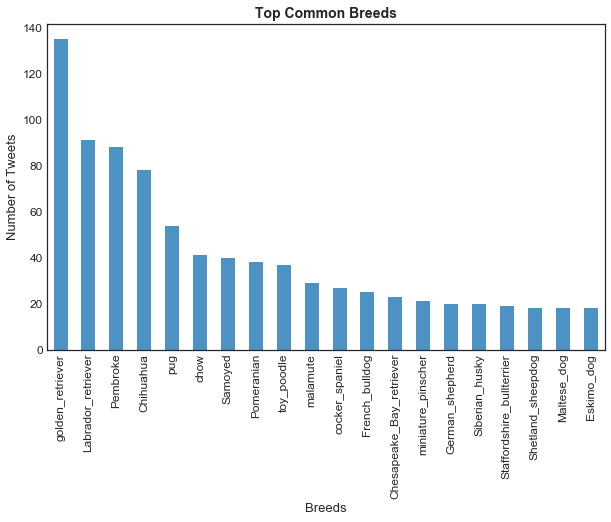

In [2279]:
# Plot the top common breeds
plt.figure(figsize=(10,6))
top_common_breeds.plot(kind='bar', alpha=0.8)
plt.title('Top Common Breeds', fontsize=14, fontweight='bold')
plt.ylabel('Number of Tweets', fontsize=13)
plt.xlabel('Breeds', fontsize=13)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12);

  We can see that there is a big difference between the most common breed in tweets and the 20th most common breed.
  Also thank to the plot we can easily see the most common breed is golden retriever.

##### 2. Breed with Highest Rating Numerator

It will be interesting to see if the most common breed in tweets actually has the highest ratings. Thus, we can now find the highest rated breeds.

In [2255]:
# Finding the breeds with the largest rating numerator
breed_highest_scores = master.groupby('predicted_breed')['rating_numerator'].mean()
breed_highest_scores = breed_highest_scores.sort_values(ascending=False)

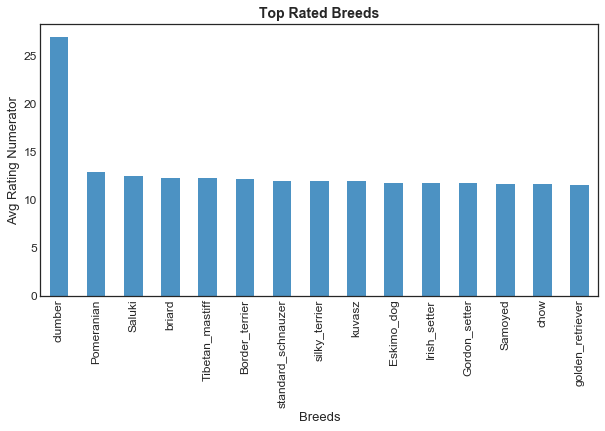

In [2280]:
# plot the top rated breeds
plt.figure(figsize=(10,5))
breed_highest_scores[:15].plot(kind='bar', alpha = 0.8)
plt.title('Top Rated Breeds', fontsize=14, fontweight='bold')
plt.ylabel('Avg Rating Numerator', fontsize=13)
plt.xlabel('Breeds', fontsize=13)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12);

Surprisingly, the average highest rated breed is not golden retriever. It is plumber and the golder retriever seems to be on an average level with other breeds.

##### 3. Are High Rating Breeds more Common?

Since we found that common breeds are not the highest rated, it will be a great idea to verify if they are really not correlated. In order to prove this, we will find the number of appearances, average rating, average favorite count, and average retweets of each breed.

In [2257]:
# Count the number of tweets in which the breeds appear
common_breeds = pd.DataFrame(master_clean.predicted_breed.value_counts())
common_breeds.reset_index(inplace=True)
common_breeds.columns = ['predicted_breed','counts']
common_breeds.head(5)

,predicted_breed,counts
0,golden_retriever,135
1,Labrador_retriever,91
2,Pembroke,88
3,Chihuahua,78
4,pug,54


In [2258]:
# averaging the number of rating_numerator, retweet and favorite 
breed_scores = master.groupby('predicted_breed')[['rating_numerator','retweet_count','favorite_count']].mean()
breed_scores = breed_scores.sort_values(by='rating_numerator',ascending=False)
breed_scores.reset_index(inplace=True)
breed_scores.head(3)

,predicted_breed,rating_numerator,retweet_count,favorite_count
0,clumber,27.000000,1807.000000,7093.000000
1,Pomeranian,12.868421,2757.973684,7914.710526
2,Saluki,12.500000,4929.000000,23485.250000


In [2259]:
# merging our breed tweets counts with the average of each breed rating, retweet and favorite count
breeds_merge = pd.merge(common_breeds,breed_scores, on='predicted_breed')
breeds_merge.head(5)

,predicted_breed,counts,rating_numerator,retweet_count,favorite_count
0,golden_retriever,135,11.585185,3593.066667,12293.548148
1,Labrador_retriever,91,11.131868,3795.494505,11794.912088
2,Pembroke,88,11.443182,3089.909091,11211.125000
3,Chihuahua,78,10.692308,2781.794872,8627.487179
4,pug,54,10.240741,1763.222222,5759.351852


Once we have all the data we need to check for the correlation of highest rated versus most common breeds, we can plot each distribution and a scatter plot to visualize their relationship better.

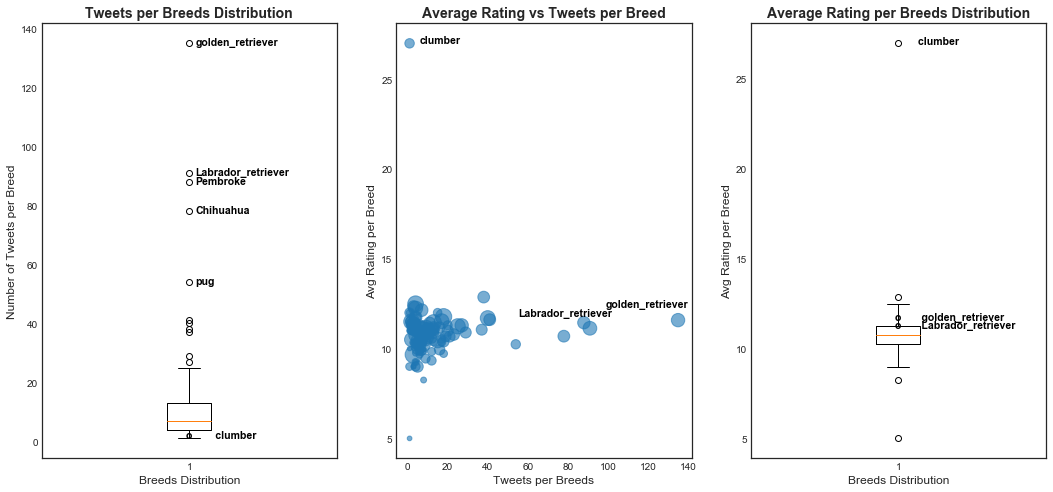

In [2260]:
# show the distribution of the breeds' tweets, ratings and the top outliers
plt.figure(figsize=(18,8))

# plot of tweets per breed distribution
plt.subplot(1,3,1)
plt.boxplot(breeds_merge.counts)
plt.title('Tweets per Breeds Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Number of Tweets per Breed', fontsize=12)
plt.xlabel('Breeds Distribution', fontsize=12)
# show labels (breed) of top 5 max outliers of tweet counts per breeds
for i in range(5):
    plt.text(1+0.02,
             breeds_merge.iloc[i].counts-0.8,
             breeds_merge.iloc[i].predicted_breed,
            color='black',
            fontsize=10.5, fontweight='bold');
# show label (breed) of the minimum value of tweet counts per breeds
plt.text(1-0.01,
             breeds_merge.iloc[-1].counts,
             'o        ' + breeds_merge.iloc[-1].predicted_breed,
            color='black',
            fontsize=10.5, fontweight='bold');
    
# plot of relationship between tweets and average ratings per breed
plt.subplot(1,3,2)
plt.scatter(x=breeds_merge.counts,y=breeds_merge.rating_numerator,
            s=breeds_merge.retweet_count/20,
           alpha = 0.6)
plt.title('Average Rating vs Tweets per Breed', fontsize=14, fontweight='bold')
plt.ylabel('Avg Rating per Breed', fontsize=12)
plt.xlabel('Tweets per Breeds', fontsize=12)
# show labels (breed) of top 2 max outliers of tweet counts per breeds
for i in range(2):
    plt.text(breeds_merge.iloc[i].counts-36,
             breeds_merge.iloc[i].rating_numerator+0.7,
             breeds_merge.iloc[i].predicted_breed,
            color='black',
            fontsize=10.5, fontweight='bold');
# show label (breed) of the minimum value of tweet counts per breeds
plt.text(breeds_merge.iloc[-1].counts+5,
            breeds_merge.iloc[-1].rating_numerator,
            breeds_merge.iloc[-1].predicted_breed,
            color='black',
            fontsize=10.5, fontweight='bold');


# plot of average ratings distribution per breed
plt.subplot(1,3,3)
plt.boxplot(breeds_merge.rating_numerator)
plt.title('Average Rating per Breeds Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Avg Rating per Breed', fontsize=12)
plt.xlabel('Breeds Distribution', fontsize=12)
# show labels (breed) of top 2 max outliers of tweet counts per breeds
for i in range(2):
    plt.text(1-0.01,
             breeds_merge.iloc[i].rating_numerator,
             'o       ' + breeds_merge.iloc[i].predicted_breed,
            color='black',
            fontsize=10.5, fontweight='bold');
# show label (breed) of the minimum value of tweet counts per breeds
plt.text(1-0.01,
             breeds_merge.iloc[-1].rating_numerator -0.08,
             '        ' + breeds_merge.iloc[-1].predicted_breed,
            color='black',
            fontsize=10.5, fontweight='bold');

From this plot it is clear that there is no correlation between the rating numerator and the number of a tweets of a breed. This means, that most popular breeds can be common enough that their ratings tend to be average. While tweets of a breed not so common are so rare that tend to catch people's attention more. 

##### 4. Favorite and Retweet Count relationship

From before we also had computed the favorite and retweet counts average values per breed. Now, we will use them to understand if favorite and retweets are correlated. Also, it will be a good way to check where common breeds are respect to high rated breed in this two categories.

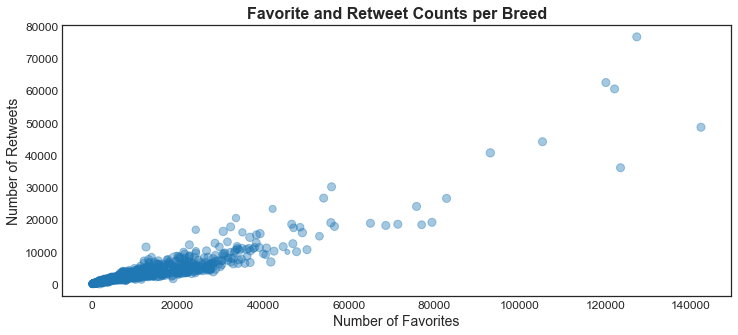

In [2261]:
# plot the relation of favorite count vs the retweet count of all dogs per tweet,
# use the rating numerator as the size of points in the scatterplot
plt.figure(figsize=(12,5))
plt.scatter(x=master.favorite_count, y = master.retweet_count,
            s = 5*master.rating_numerator, alpha = 0.4)
plt.title('Favorite and Retweet Counts per Breed', fontsize=16, fontweight='bold')
plt.xlabel('Number of Favorites', fontsize=14)
plt.ylabel('Number of Retweets', fontsize=14)
plt.xticks( fontsize=12)
plt.yticks( fontsize=12);

It looks clear that the favorite and retweet counts are correlated, so we will use now our average values per breed to check how they correlate. Also, it is important to use the number of apperances divided by rating numerator of each breed to learn more from our plot how the breeds stand against each other.

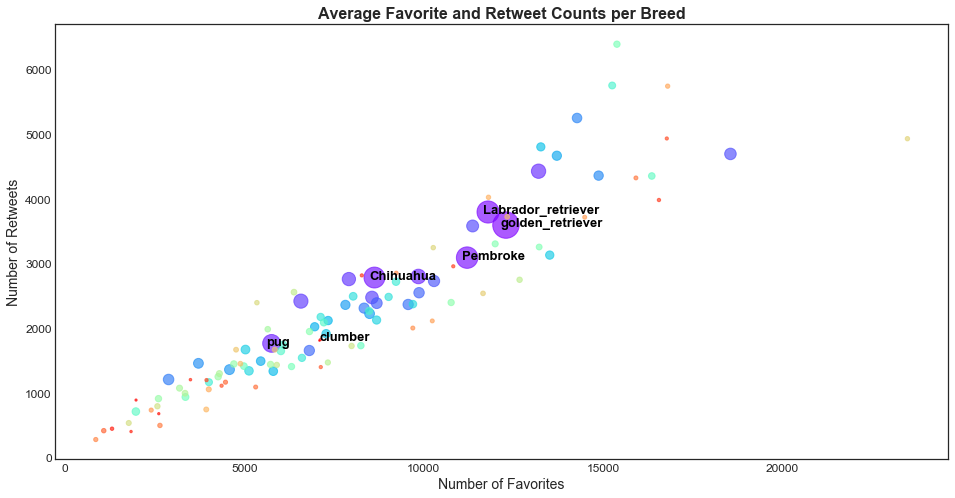

In [2262]:
# Plot the relation of favorite versus retweet counts and use the number of tweets for the size of dots
plt.figure(figsize=(16,8))
plt.scatter(x=breeds_merge.favorite_count,y=breeds_merge.retweet_count,
            s=60*breeds_merge.counts/breeds_merge.rating_numerator,
            c=[i for i in range(breeds_merge.shape[0])], cmap='rainbow', alpha = 0.65);
plt.title('Average Favorite and Retweet Counts per Breed', fontsize=16, fontweight='bold')
plt.xlabel('Number of Favorites', fontsize=14)
plt.ylabel('Number of Retweets', fontsize=14)
plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
# show labels (breed) of top 5 favorite vs retweet breed
for i in range(5):
    plt.text(breeds_merge.iloc[i].favorite_count-150,
             breeds_merge.iloc[i].retweet_count-20,
             breeds_merge.iloc[i].predicted_breed,
            color='black',
            fontsize=13, fontweight='bold');
# show the labels of the highest rated breed
plt.text(breeds_merge.iloc[-1].favorite_count,
             breeds_merge.iloc[-1].retweet_count,
             breeds_merge.iloc[-1].predicted_breed,
            color='black',
            fontsize=13, fontweight='bold');

From this plot we can learn a lot fo information, we can see that the top 5 most common breeds actually are not the ones with the highest number of retweets or favorites. However, neither does the highest rated breed (clumber). 
Another interesting factor is that average number of favorites is almost 4 times greater than the retweets.
Finally, we can discard the idea that less common breeds catch people attention more since the number of retweets for the highest rated breed is actually lower than common breeds.

##### 5. Sources Proportions

Another interesting question is what percentage of tweets came from which source.
We can invetsigate this to understand when user might tweet.

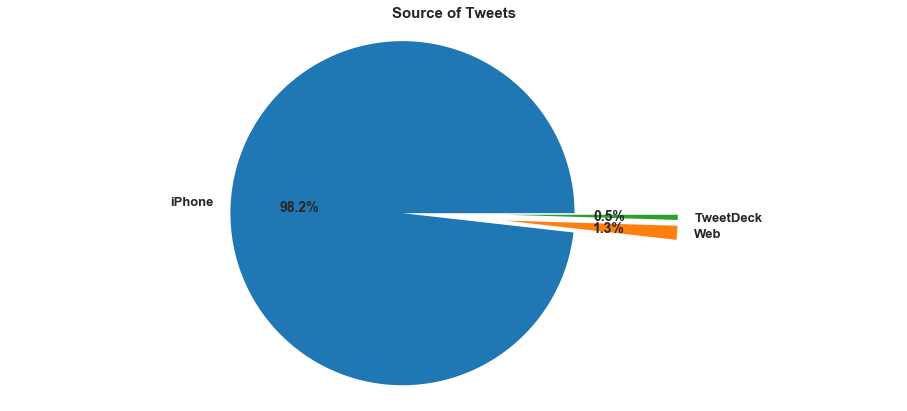

In [2263]:
# extracting labels and percentages of tweets source
source_proportions = 100.0 * master.source.value_counts()/master.tweet_id.nunique()

# labels on the pie chart
labels = source_proportions.index
# percentage of each source
sizes = source_proportions.values
explode = (0.0, 0.6, 0.6)  

# Pie chart of source of tweets
plt.figure(figsize=(16,7))
patches, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=360)
# Equal axis aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal');

# labels 
plt.title('Source of Tweets', fontsize=15, fontweight='bold')
for i,t in enumerate(texts):
    texts[i].set_fontsize(13)
    texts[i].set_fontweight('bold')
    autotexts[i].set_fontsize(14)
    autotexts[i].set_fontweight('bold');


Since the iPhone is the overwhelming 98.2% of the tweets, we can say that they take pictures with the phone and upload them using the mobile, so we can understand this is more convenient for user.

##### 6. Tweets over Time and per Weekday

Finally, it will be vary valuable to see how the WeRateDogs account is performing over the years and when they have tweets peaks.

In [2264]:
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452 entries, 0 to 1451
Data columns (total 18 columns):
tweet_id              1452 non-null int64
timestamp             1452 non-null datetime64[ns]
source                1452 non-null object
text                  1452 non-null object
expanded_urls         1452 non-null object
rating_numerator      1452 non-null int64
rating_denominator    1452 non-null int64
name                  1452 non-null object
stage                 1452 non-null object
jpg_url               1452 non-null object
img_num               1452 non-null int64
prediction            1452 non-null object
predicted_breed       1452 non-null object
probability           1452 non-null float64
isDog                 1452 non-null bool
favorite_count        1452 non-null int64
retweet_count         1452 non-null int64
retweeted             1452 non-null bool
dtypes: bool(2), datetime64[ns](1), float64(1), int64(6), object(8)
memory usage: 184.4+ KB


In [2265]:
# compute a dataframe to compare the monthly trends of tweets, favorites and retweets
ts = master.groupby([master['timestamp'].dt.year, master['timestamp'].dt.month] )[['tweet_id']].count()
ts[['favorite_count/5K','retweet_count/5K']] = master.groupby([master['timestamp'].dt.year, master['timestamp'].dt.month] )\
[['favorite_count', 'retweet_count']].sum()/5000

# show the compacted datframe
ts.head(3)

tweet_id  favorite_count/5K  retweet_count/5K
timestamp timestamp                                               
2015      11              192            45.8934           17.8840
          12              240           149.6708           61.7716
2016      1               123            87.0312           30.8254

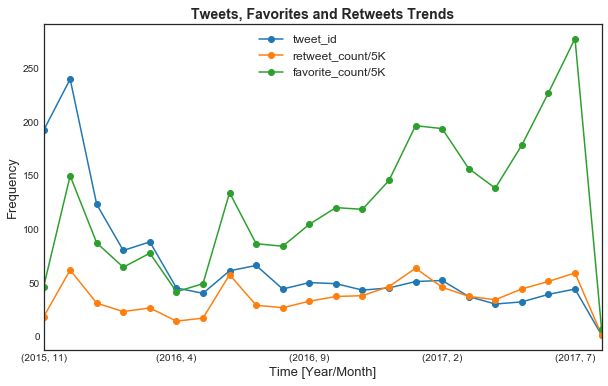

In [2266]:
# plot the trends in time of tweets, favorites and retweets
ts[['tweet_id','retweet_count/5K','favorite_count/5K']].plot(marker='o', figsize=(10,6))
plt.title('Tweets, Favorites and Retweets Trends', fontsize = 14, fontweight ='bold')
plt.ylabel('Frequency', fontsize = 13)
plt.xlabel('Time [Year/Month]', fontsize = 13)
plt.legend(fontsize=12);

In [2267]:
# creating a timeseries to sample data in different periods of time
ts = master.set_index(pd.DatetimeIndex(master['timestamp']))
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1452 entries, 2017-08-01 00:17:27 to 2016-06-03 01:07:16
Data columns (total 18 columns):
tweet_id              1452 non-null int64
timestamp             1452 non-null datetime64[ns]
source                1452 non-null object
text                  1452 non-null object
expanded_urls         1452 non-null object
rating_numerator      1452 non-null int64
rating_denominator    1452 non-null int64
name                  1452 non-null object
stage                 1452 non-null object
jpg_url               1452 non-null object
img_num               1452 non-null int64
prediction            1452 non-null object
predicted_breed       1452 non-null object
probability           1452 non-null float64
isDog                 1452 non-null bool
favorite_count        1452 non-null int64
retweet_count         1452 non-null int64
retweeted             1452 non-null bool
dtypes: bool(2), datetime64[ns](1), float64(1), int64(6), object(8)
memory usage: 19

In [2268]:
# sample the data by year quarters and 
FREQ_SAMPLE = 'Q'
ts_quarter = ts.resample(FREQ_SAMPLE)[['tweet_id',]].count()
ts_quarter[['favorite_count/5K','retweet_count/5K']] = ts.resample(FREQ_SAMPLE)\
[['favorite_count', 'retweet_count']].sum()/5000

ts_quarter.head(3)

,tweet_id,favorite_count/5K,retweet_count/5K
timestamp,,,
2015-12-31,432,195.5642,79.6556
2016-03-31,291,228.8750,80.1360
2016-06-30,146,224.3978,88.2368


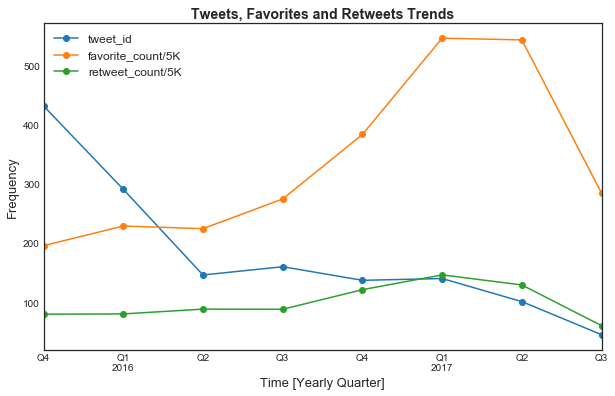

In [2269]:
# plot the quarter count of tweets, favorites and retweets
ts_quarter.plot(marker='o', figsize=(10,6))
plt.title('Tweets, Favorites and Retweets Trends', fontsize = 14, fontweight ='bold')
plt.ylabel('Frequency', fontsize = 13)
plt.xlabel('Time [Yearly Quarter]', fontsize = 13)
plt.legend(fontsize=12);

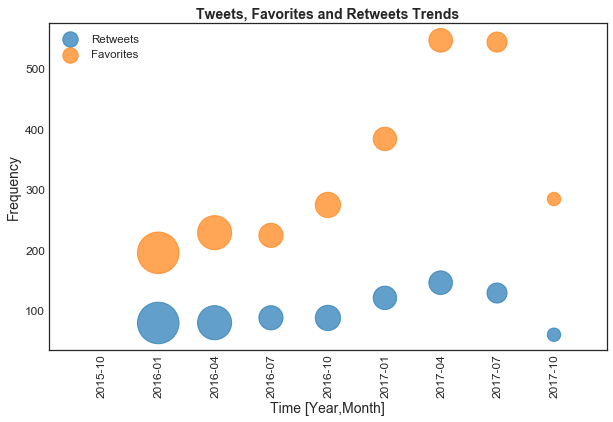

In [2270]:
# plot the quarter count of tweets, favorites and retweets
plt.figure(figsize=(10,6))
plt.scatter(x=ts_month.index, y =ts_month['retweet_count/5K'],
            s=4*ts_month['tweet_id'], alpha=0.7, label='Retweets');
plt.scatter(x=ts_month.index, y =ts_month['favorite_count/5K'],
            s=4*ts_month['tweet_id'], alpha=0.7, label='Favorites');
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Tweets, Favorites and Retweets Trends', fontsize = 14, fontweight ='bold')
plt.ylabel('Frequency', fontsize = 14)
plt.xlabel('Time [Year,Month]', fontsize = 14)
plt.legend(fontsize=11.5, loc='upper left', markerscale=0.5);

In [2271]:
# create a time series that samples per day the number of tweets
ts_day = ts.resample('D')[['tweet_id']].count()

In [2272]:
# label the weekdays in the tweets per day time series using our timestamp
ts_day['weekday'] = ts_day.index.strftime('%A')
ts_day.head(10)

,tweet_id,weekday
timestamp,,
2015-11-15,3,Sunday
2015-11-16,18,Monday
2015-11-17,13,Tuesday
2015-11-18,10,Wednesday
2015-11-19,19,Thursday
2015-11-20,14,Friday
2015-11-21,9,Saturday
2015-11-22,13,Sunday
2015-11-23,13,Monday


In [2273]:
# grouping tweets by weekdays to count the number of tweets in every weekday
ts_day_group = ts_day.groupby([ts_day.index.year,'weekday'])[['tweet_id']].sum()
ts_day_group.sort_values(by='tweet_id',inplace=True,ascending=False)
ts_day_group.head(20)

tweet_id
timestamp weekday            
2016      Monday          116
          Tuesday         108
          Wednesday       106
          Friday          106
          Thursday        104
          Saturday         98
          Sunday           96
2015      Monday           74
          Thursday         71
          Sunday           65
          Tuesday          62
          Wednesday        57
          Friday           52
          Saturday         51
2017      Friday           50
          Monday           43
          Thursday         42
          Tuesday          42
          Wednesday        42
          Saturday         35

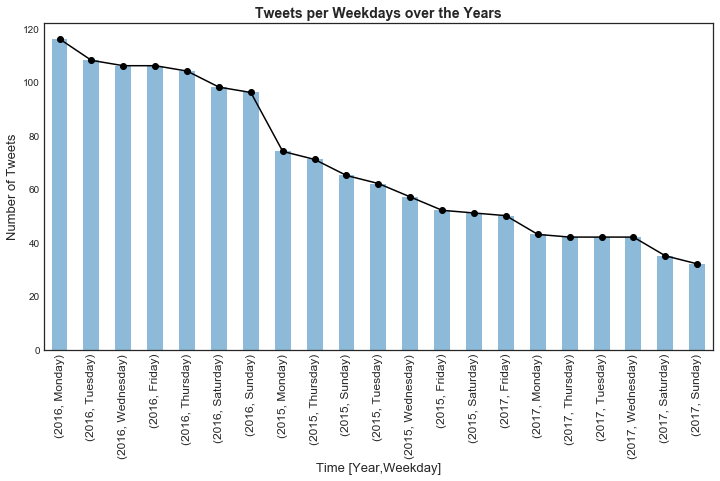

In [2274]:
# plot of tweets counts per weekday over the years 2015 to 2017
ts_day_group['tweet_id'].plot(kind='line', figsize=(12,6),  color='k', marker='o');
ts_day_group['tweet_id'].plot(kind='bar', alpha =0.5);
plt.title('Tweets per Weekdays over the Years', fontsize=14, fontweight='bold')
plt.ylabel('Number of Tweets', fontsize=13)
plt.xlabel('Time [Year,Weekday]', fontsize=13)
plt.xticks(fontsize=12);

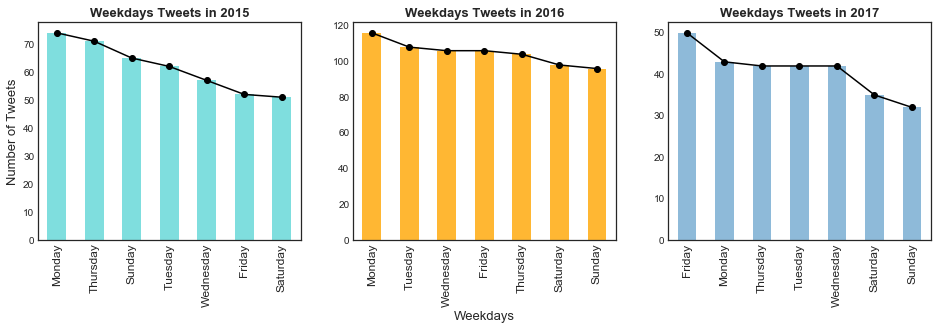

In [2275]:
# Tweets counts per weekdays in every year
plt.figure(figsize=(16,4))

# Tweets per weekdays in 2015
plt.subplot(1,3,1)
ts_day_group.loc[2015]['tweet_id'].plot(kind='line', color='k', marker='o');
ts_day_group.loc[2015]['tweet_id'].plot(kind='bar', alpha =0.5, color = 'c')
plt.title('Weekdays Tweets in 2015', fontsize=13, fontweight='bold')
plt.ylabel('Number of Tweets', fontsize=13)
plt.xlabel('')
plt.xticks(fontsize=12)

# Tweets per weekdays in 2016
plt.subplot(1,3,2)
ts_day_group.loc[2016]['tweet_id'].plot(kind='line', color='k', marker='o');
ts_day_group.loc[2016]['tweet_id'].plot(kind='bar', alpha =0.8, color = 'orange')
plt.title('Weekdays Tweets in 2016', fontsize=13, fontweight='bold')
plt.xlabel('Weekdays', fontsize=13)
plt.xticks(fontsize=12)

# Tweets per weekdays in 2017
plt.subplot(1,3,3)
ts_day_group.loc[2017]['tweet_id'].plot(kind='line', color='k', marker='o');
ts_day_group.loc[2017]['tweet_id'].plot(kind='bar', alpha =0.5)
plt.title('Weekdays Tweets in 2017', fontsize=13, fontweight='bold')
plt.xlabel('')
plt.xticks(fontsize=12);
